In [100]:
import pandas as pd
import datetime as dp
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from prettytable import PrettyTable

In [2]:
dataset_path = 'E:/Datasets/titanic/raw dataset'

In [3]:
train_raw = pd.read_csv(f'{dataset_path}/train.csv')
test_raw = pd.read_csv(f'{dataset_path}/test.csv')

# Summary

In [4]:
train_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
def count_infs(series):
    if pd.api.types.is_numeric_dtype(series):
        return np.isinf(series).sum()
    return 0

summary = pd.DataFrame({
    'dtype': train_raw.dtypes,
    'n_nans': train_raw.isna().sum(),
    'n_infs': train_raw.apply(count_infs)
})
summary.reset_index(inplace=True)
summary.rename(columns={'index': 'column'}, inplace=True)
print(summary)

         column    dtype  n_nans  n_infs
0   PassengerId    int64       0       0
1      Survived    int64       0       0
2        Pclass    int64       0       0
3          Name   object       0       0
4           Sex   object       0       0
5           Age  float64     177       0
6         SibSp    int64       0       0
7         Parch    int64       0       0
8        Ticket   object       0       0
9          Fare  float64       0       0
10        Cabin   object     687       0
11     Embarked   object       2       0


Same for the test set

In [13]:
summary = pd.DataFrame({
    'dtype': test_raw.dtypes,
    'n_nans': test_raw.isna().sum(),
    'n_infs': test_raw.apply(count_infs)
})
summary.reset_index(inplace=True)
summary.rename(columns={'index': 'column'}, inplace=True)
print(summary)

         column    dtype  n_nans  n_infs
0   PassengerId    int64       0       0
1        Pclass    int64       0       0
2          Name   object       0       0
3           Sex   object       0       0
4           Age  float64      86       0
5         SibSp    int64       0       0
6         Parch    int64       0       0
7        Ticket   object       0       0
8          Fare  float64       1       0
9         Cabin   object     327       0
10     Embarked   object       0       0


In [37]:
all_columns = train_raw.columns
feature_names = all_columns[~np.isin(all_columns, ['Survived', 'PassengerId', 'Name'])] #All columns that will be used for prediction

In [34]:
train_raw.duplicated().sum()

np.int64(0)

In [35]:
test_raw.duplicated().sum()

np.int64(0)

No duplicated values

# Wrangling

I'll start wrangling the dataset a little bit.
Lets map the sex column to a numerical value:

In [24]:
train_w = train_raw.copy()
test_w = test_raw.copy()
train_w['Sex'] = train_w['Sex'].map({'male': 0, 'female': 1})
test_w['Sex'] = test_w['Sex'].map({'male': 0, 'female': 1})

There are three columns with missing data. I could simply drop the two rows for the embarked column, it wont do much difference.

In [25]:
train_w = train_w.dropna(subset=['Embarked'])

In [26]:
train_w.loc[:, 'Cabin'] = train_w['Cabin'].fillna('unknown')
test_w.loc[:, 'Cabin'] = test_w['Cabin'].fillna('unknown')

The age column has a lot of nans, and I don't know how could this be afecting.

In [39]:
print(train_w[numerical_cols].corr())

          Pclass       Age     SibSp     Parch      Fare
Pclass  1.000000 -0.390938  0.081656  0.016824 -0.548193
Age    -0.390938  1.000000 -0.319953 -0.213799  0.086169
SibSp   0.081656 -0.319953  1.000000  0.414542  0.160887
Parch   0.016824 -0.213799  0.414542  1.000000  0.217532
Fare   -0.548193  0.086169  0.160887  0.217532  1.000000


I am going to impute missing values by training a small RandomForest predictor

In [28]:
features = ['Pclass', 'SibSp', 'Parch', 'Fare', 'Sex'] #Even if fare has a small correlation could be helpfull

train_age = train_w[train_w['Age'].notna()].copy()
test_age = train_w[train_w['Age'].isna()].copy()

X_train = train_age[features]
y_train = train_age['Age']
X_test = test_age[features]

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

predicted_ages = model.predict(X_test) #Predict missing values

train_w.loc[train_w['Age'].isna(), 'Age'] = predicted_ages #Fill the dataset, imputing the data

In [29]:
#And I repeat for the test set, using the same predictor
pred_age = test_w[test_w['Age'].isna()].copy()
X_pred = pred_age[features]

predicted_ages = model.predict(X_pred)

test_w.loc[test_w['Age'].isna(), 'Age'] = predicted_ages

In [33]:
#And finally I won get myself preocupied for the only one NaN fare value, i'll replace it with the mean 
test_w.loc[test_w['Fare'].isna(), 'Fare'] = 32.204208

# Univariate analysis

## Numerical values

In [67]:
#Numerical data
numerical_cols = train_w[feature_names].describe().columns
numerical_cols = numerical_cols[~np.isin(numerical_cols, ['Sex', 'SibSp', 'Parch', 'Pclass'])] #Sex and Pclass gets into this group for the transformation, they are categorical
train_w[numerical_cols].describe()  

,Age,Fare
count,889.000000,889.000000
mean,29.536130,32.096681
std,13.696944,49.697504
min,0.420000,0.000000
25%,21.000000,7.895800
50%,28.000000,14.454200
75%,37.000000,31.000000
max,80.000000,512.329200


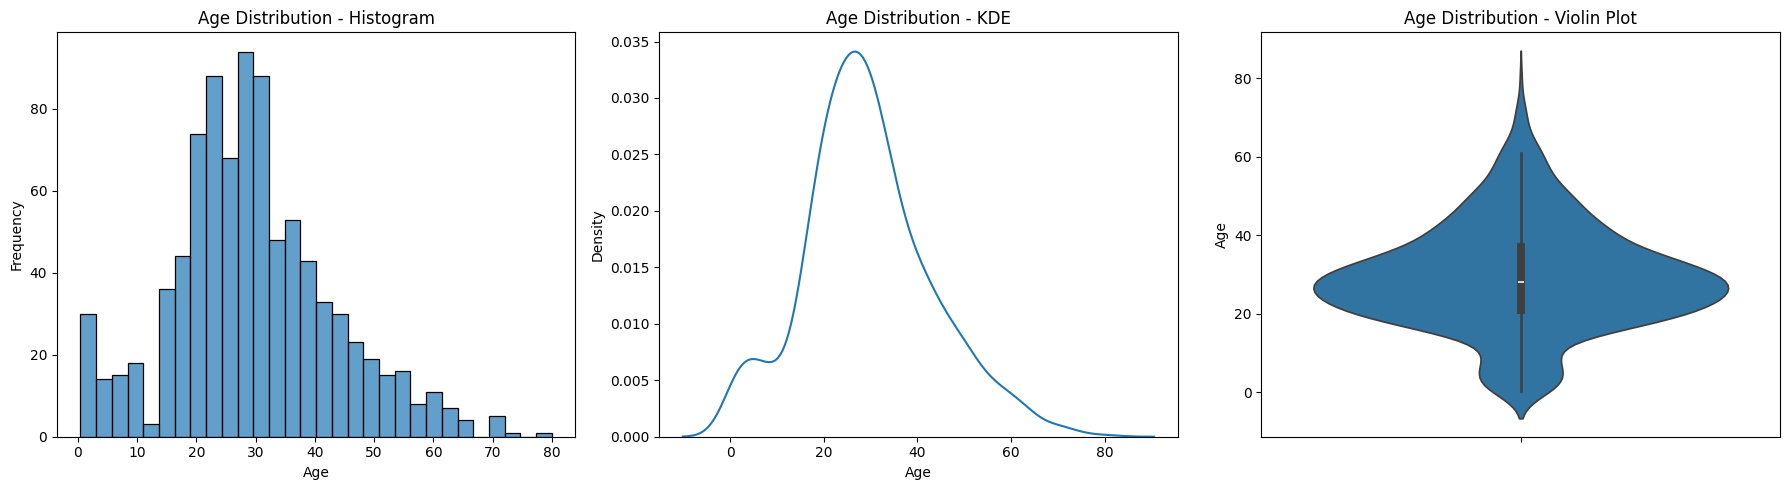

In [78]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

sns.histplot(train_w['Age'].dropna(), bins=30, kde=False, edgecolor='k', alpha=0.7, ax=axes[0])
axes[0].set_title('Age Distribution - Histogram')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')

sns.kdeplot(train_w['Age'].dropna(), ax=axes[1])
axes[1].set_title('Age Distribution - KDE')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Density')

sns.violinplot(y=train_w['Age'].dropna(), ax=axes[2])
axes[2].set_title('Age Distribution - Violin Plot')
axes[2].set_xlabel('')  # No label for x-axis
axes[2].set_ylabel('Age')

plt.tight_layout()
plt.show()

There is an important bias towards babies and some bimodality aswell

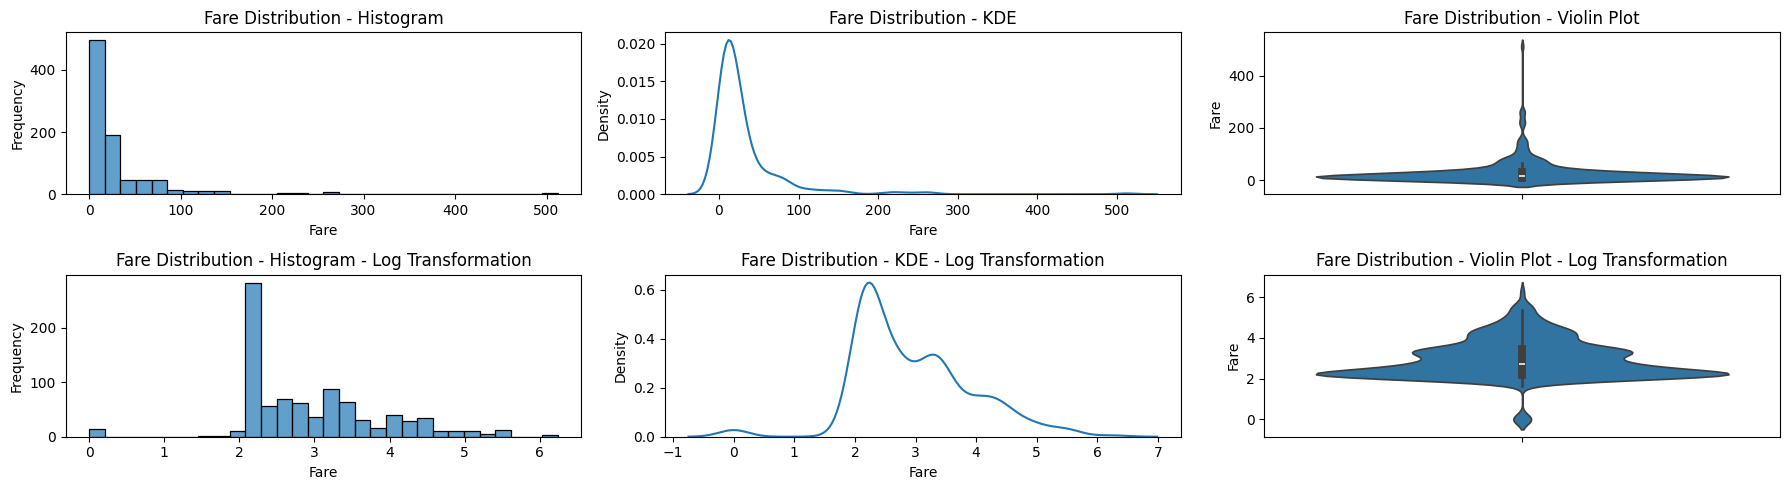

In [85]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 5))
subset = train_w.copy()
subset['Fare_log'] = np.log1p(subset['Fare'])

sns.histplot(train_w['Fare'], bins=30, kde=False, edgecolor='k', alpha=0.7, ax=axes[0, 0])
axes[0, 0].set_title('Fare Distribution - Histogram')
axes[0, 0].set_xlabel('Fare')
axes[0, 0].set_ylabel('Frequency')

sns.kdeplot(train_w['Fare'], ax=axes[0, 1])
axes[0, 1].set_title('Fare Distribution - KDE')
axes[0, 1].set_xlabel('Fare')
axes[0, 1].set_ylabel('Density')

sns.violinplot(y=train_w['Fare'], ax=axes[0, 2])
axes[0, 2].set_title('Fare Distribution - Violin Plot')
axes[0, 2].set_xlabel('')  # No label for x-axis
axes[0, 2].set_ylabel('Fare')

sns.histplot(subset['Fare_log'], bins=30, kde=False, edgecolor='k', alpha=0.7, ax=axes[1, 0])
axes[1, 0].set_title('Fare Distribution - Histogram - Log Transformation')
axes[1, 0].set_xlabel('Fare')
axes[1, 0].set_ylabel('Frequency')

sns.kdeplot(subset['Fare_log'], ax=axes[1, 1])
axes[1, 1].set_title('Fare Distribution - KDE - Log Transformation')
axes[1, 1].set_xlabel('Fare')
axes[1, 1].set_ylabel('Density')

sns.violinplot(y=subset['Fare_log'], ax=axes[1, 2])
axes[1, 2].set_title('Fare Distribution - Violin Plot - Log Transformation')
axes[1, 2].set_xlabel('')  # No label for x-axis
axes[1, 2].set_ylabel('Fare')

plt.tight_layout()
plt.show()

There is a marked asymmetry to the right.

This distribution probably has some outliers due to the rich passengers. Given that I am thinking to train a Random Forest Model it shouldn't be necessary to use the log transformation in it, but it is helpfull here in the visualization

In [88]:
train_w[['Age', 'Fare', 'Survived']].corr()

,Age,Fare,Survived
Age,1.000000,0.086169,-0.073897
Fare,0.086169,1.000000,0.255290
Survived,-0.073897,0.255290,1.000000


There is a "strong" overal correlation between Fare and survival, leaning towards a better chance increasing with the price of the ticket. It doesnt show too much for the age variable, but this could be due to a sum of different tendencies.

In [94]:
subset = train_w.copy()
bins = [0, 3, 12, 18, 35, 60, np.inf]
labels = ['Toddler', 'Child', 'Teenager', 'Young Adult', 'Adult', 'Senior']
subset['Age_group'] = pd.cut(subset['Age'], bins=bins, labels=labels, right=False)

age_group_dummies = pd.get_dummies(subset['Age_group'], prefix='AgeGroup')
subset = pd.concat([subset, age_group_dummies.astype(int)], axis=1)
newlabels = [f'AgeGroup_{label}' for label in labels]
newlabels.append('Survived')
subset[newlabels].corr()

,AgeGroup_Toddler,AgeGroup_Child,AgeGroup_Teenager,AgeGroup_Young Adult,AgeGroup_Adult,AgeGroup_Senior,Survived
AgeGroup_Toddler,1.000000,-0.041940,-0.041940,-0.184590,-0.102161,-0.028912,0.083133
AgeGroup_Child,-0.041940,1.000000,-0.063397,-0.279027,-0.154426,-0.043703,0.046238
AgeGroup_Teenager,-0.041940,-0.063397,1.000000,-0.279027,-0.154426,-0.043703,0.036463
AgeGroup_Young Adult,-0.184590,-0.279027,-0.279027,1.000000,-0.679671,-0.192350,-0.067020
AgeGroup_Adult,-0.102161,-0.154426,-0.154426,-0.679671,1.000000,-0.106456,0.021107
AgeGroup_Senior,-0.028912,-0.043703,-0.043703,-0.192350,-0.106456,1.000000,-0.054174
Survived,0.083133,0.046238,0.036463,-0.067020,0.021107,-0.054174,1.000000


In [96]:
subset = train_w.copy()
bins = [0, 8, 15, 31, np.inf]
labels = ['Very Low', 'Low', 'Medium', 'High']
subset['Fare_group'] = pd.cut(subset['Age'], bins=bins, labels=labels, right=False)

age_group_dummies = pd.get_dummies(subset['Fare_group'], prefix='Fare_group')
subset = pd.concat([subset, age_group_dummies.astype(int)], axis=1)
newlabels = [f'Fare_group_{label}' for label in labels]
newlabels.append('Survived')
subset[newlabels].corr()

,Fare_group_Very Low,Fare_group_Low,Fare_group_Medium,Fare_group_High,Survived
Fare_group_Very Low,1.000000,-0.052995,-0.250612,-0.209786,0.129342
Fare_group_Low,-0.052995,1.000000,-0.205367,-0.171911,-0.013336
Fare_group_Medium,-0.250612,-0.205367,1.000000,-0.812966,-0.053306
Fare_group_High,-0.209786,-0.171911,-0.812966,1.000000,-0.003219
Survived,0.129342,-0.013336,-0.053306,-0.003219,1.000000


Interestingly, there is a higher correlation with survival at a lower price.

## Categorical values

In [69]:
train_w['SibSp'].value_counts()

SibSp
0    606
1    209
2     28
4     18
3     16
8      7
5      5
Name: count, dtype: int64

In [68]:
train_w['Parch'].value_counts()

Parch
0    676
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64

In [71]:
#Categorical data
categorical_cols = train_w[feature_names].describe(include='object').columns
categorical_cols = np.append(categorical_cols, ['Sex', 'SibSp', 'Parch', 'Pclass']) #Those that got left behind
subset = train_w.copy()
subset['Sex'] = train_w['Sex'].map({0 : 'male', 1 : 'female'})
subset['SibSp'] = train_w['SibSp'].map({0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 8: '8'})
subset['Parch'] = train_w['Parch'].map({0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6'})
subset['Pclass'] = train_w['Pclass'].map({1 : 'first', 2 : 'second', 3 : 'third'})
subset[categorical_cols].describe(include='object') 

,Ticket,Cabin,Embarked,Sex,SibSp,Parch,Pclass
count,889,889,889,889,889,889,889
unique,680,147,3,2,7,7,3
top,347082,unknown,S,male,0,0,third
freq,7,687,644,577,606,676,491


This description reveals a notable dominance of class 3, a higher proportion of male passengers, and a large number of people traveling without siblings/spouses or parents/children on board. In addition, cabin information is largely absent.

Sex is already a one hot encoded value, so we leave it like that. Pclass, which is categorical is also ordinal, so we can again leave it be like that

In [63]:
contingency_table = pd.crosstab(train_w['CabinNumber'], train_w['Survived'])
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

array(['Ticket', 'Cabin', 'Embarked', 'Sex', 'Pclass'], dtype=object)

In [106]:
table = PrettyTable()
table.field_names = ['Variable', 'Chi2 stat', 'p value', 'dof']
for variable in categorical_cols:
    contingency_table = pd.crosstab(train_w[variable], train_w['Survived'])
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    table.add_row([variable, f'{chi2_stat:.2f}', f'{p_value:.4f}', dof])

print(table)

+----------+-----------+---------+-----+
| Variable | Chi2 stat | p value | dof |
+----------+-----------+---------+-----+
|  Ticket  |   764.40  |  0.0124 | 679 |
|  Cabin   |   238.11  |  0.0000 | 146 |
| Embarked |   26.49   |  0.0000 |  2  |
|   Sex    |   258.43  |  0.0000 |  1  |
|  SibSp   |   37.74   |  0.0000 |  6  |
|  Parch   |   28.40   |  0.0001 |  6  |
|  Pclass  |   100.98  |  0.0000 |  2  |
+----------+-----------+---------+-----+


Every single variable has a very low p value. This means that in each case we cannot discart the cero hypotesis, so there must be a relation between survival chance and each variable